#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Подготовить и проанализировать данные с дискретностью 1 час.
2. Исследовать несколько разных моделей.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Загрузка библиотек и данных

Загрузка библиотек:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

Загузка данных:

In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

Ресемплируем данные:

In [3]:
taxi_data = taxi_data.resample('1h').sum()

### Ознакомление с данными

In [4]:
display(taxi_data.info())
display(taxi_data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные соответствуют описанию и не содержат пропусков. Перейдем к анализу данных.

## Анализ

Рассмотрим за какой период предоставлены данные:

In [5]:
print(f"Начало периода: {taxi_data.index.min()}")
print(f"Конец периода: {taxi_data.index.max()}")

Начало периода: 2018-03-01 00:00:00
Конец периода: 2018-08-31 23:00:00


Все данные приходятся на 2018 год. Рассмотрим тренд и сезонность изменения почасовых заказов такси:

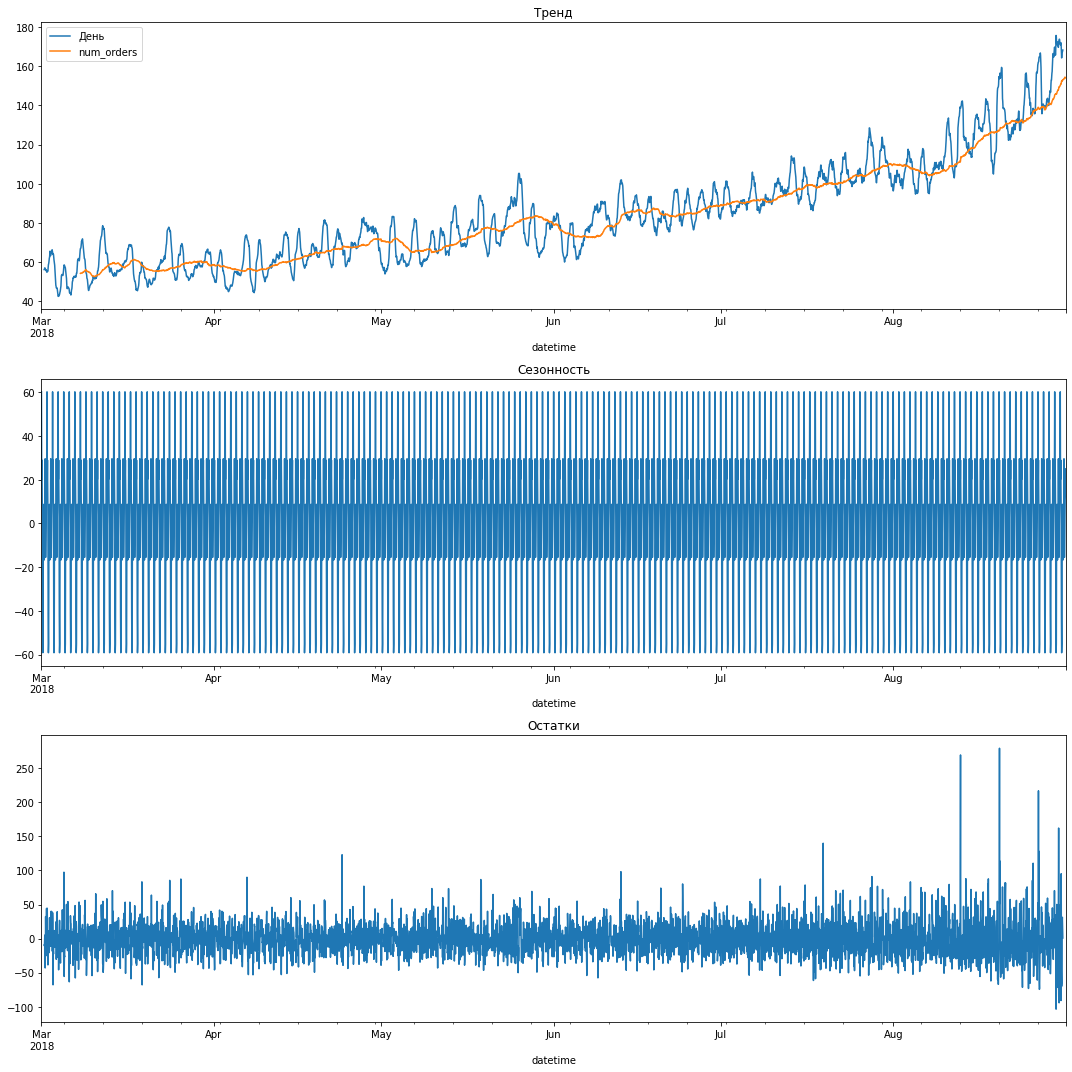

In [6]:
HOURS_IN_WEEK = 7*24

plt.figure(figsize=(15, 15))

plt.subplot(311)
seasonal_decompose(taxi_data).trend.plot(ax=plt.gca(), label='День')
taxi_data.shift().rolling(HOURS_IN_WEEK).mean().plot(ax=plt.gca(), label='Средние за неделю')
plt.legend()
plt.title('Тренд')

plt.subplot(312)
seasonal_decompose(taxi_data).seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
seasonal_decompose(taxi_data).resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

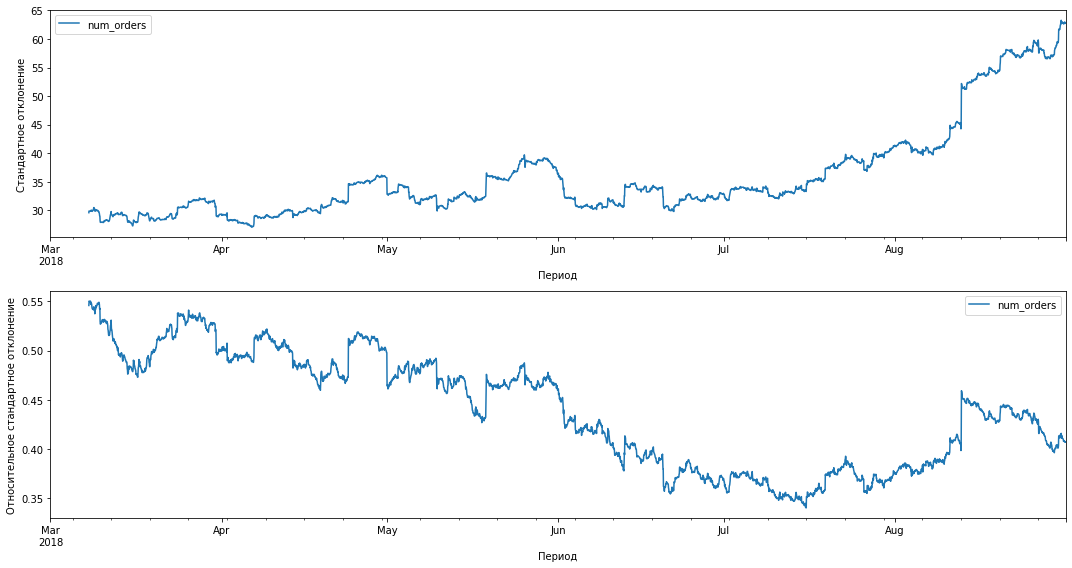

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(211)
taxi_data.rolling(HOURS_IN_WEEK).std().plot(ax=plt.gca())
plt.xlabel('Период')
plt.ylabel('Стандартное отклонение')

plt.subplot(212)
(taxi_data.rolling(HOURS_IN_WEEK).std() / taxi_data.rolling(HOURS_IN_WEEK).mean()).plot(ax=plt.gca())
plt.xlabel('Период')
plt.ylabel('Относительное стандартное отклонение')

plt.tight_layout()
plt.show()

Существует длинный тренд (в рамках недель и более длинных периодов). При этом в течение дня и недели наблюдаются существенные колебания. Имеет смысл рассмотреть скользящие средние и скользящие стандратные отклонения за недельный и месячный период.  
Рассмотрим автокорреляционную функцию для числа поездок в час:

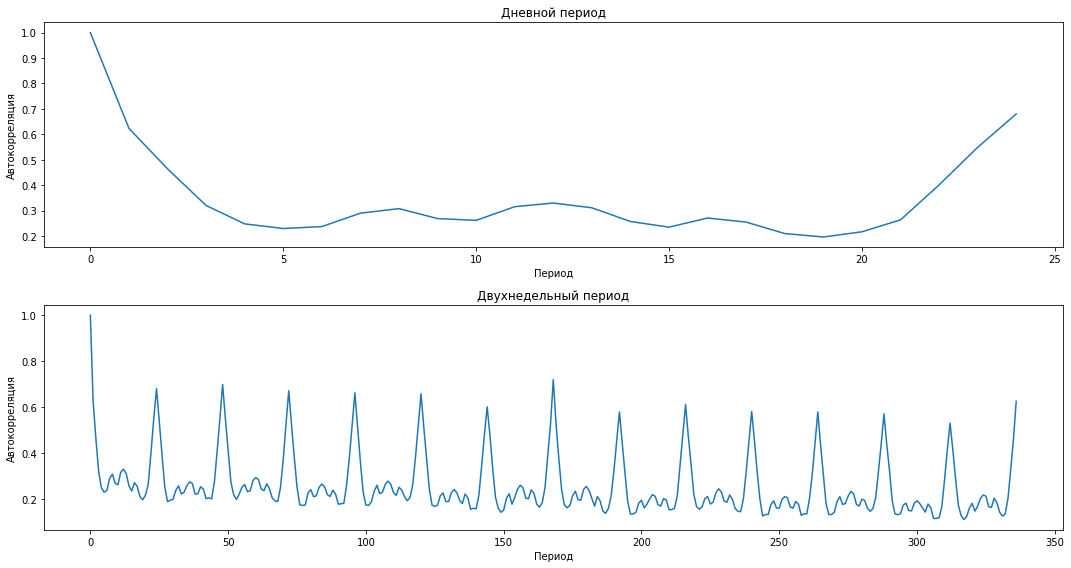

In [8]:
HOURS_IN_TWO_WEEK = 2*HOURS_IN_WEEK
HOURS_IN_DAY = 24
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(acf(taxi_data, nlags=HOURS_IN_DAY))
plt.xlabel('Период')
plt.ylabel('Автокорреляция')
plt.title('Дневной период')
plt.subplot(212)
plt.plot(acf(taxi_data, nlags=HOURS_IN_TWO_WEEK))
plt.xlabel('Период')
plt.ylabel('Автокорреляция')
plt.title('Двухнедельный период')
plt.tight_layout()
plt.show()

Автокорреляция резко падает в течение 4 часов, далее наблюдается небольшой максимум через 12 часов, а также суточный и недельный максимумы. Следовательно в качестве признаков модели можно использовать смещение на 1-4, 12, 24 и 168 часов. Добавим новые признаки:

In [9]:
for k, v in {'week':HOURS_IN_WEEK, 'month':4*HOURS_IN_WEEK}.items():
    taxi_data[f'rolling_{k}_mean'] = taxi_data['num_orders'].shift().rolling(v).mean()
    taxi_data[f'rolling_{k}_std'] = taxi_data['num_orders'].shift().rolling(v).std()

def make_lag_features(data, lags : list):
    for lag in lags:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    return data
make_lag_features(taxi_data, lags=[1,2,3,4,12,24,168]).sample(5)

,num_orders,rolling_week_mean,rolling_week_std,rolling_month_mean,rolling_month_std,lag_1,lag_2,lag_3,lag_4,lag_12,lag_24,lag_168
datetime,,,,,,,,,,,,
2018-04-06 19:00:00,63,55.732143,27.201945,57.601190,28.951399,49.0,79.0,98.0,86.0,31.0,35.0,64.0
2018-03-01 03:00:00,66,NaN,NaN,NaN,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-04-24 10:00:00,74,67.922619,34.531422,61.168155,30.788350,58.0,54.0,17.0,2.0,97.0,104.0,82.0
2018-04-24 01:00:00,77,67.642857,34.648325,60.988095,30.841016,253.0,60.0,97.0,53.0,71.0,74.0,78.0
2018-03-02 10:00:00,54,NaN,NaN,NaN,NaN,45.0,46.0,7.0,11.0,113.0,64.0,NaN


**Выводы**

1. Данные представлены в ожидаемой форме и не содержат явных аномалий.
2. Наблюдается тренд к увеличению среднего недельного и месячного числа заказов такси, а также стандартного отклонения числа заказов такси за аналогичные периоды.
3. Наблюдается спадающая автокорреляция в период 1-4 часа, а также через 6, 12, 24 (1 сутки) и 168 (1 неделя) часов.

## Обучение

Подготовим данные для обучения и тестирования моделей:

In [10]:
# Выделение тестовой выборки:
train_val, test = train_test_split(taxi_data, test_size=0.1, shuffle=False)

# Выделение обучающей и валидационной выборок:
train, val = train_test_split(train_val, test_size=0.1, shuffle=False)

# Из-за смещения при формировании новых признаков 
# в обучающей выборке некоторые значения отсутствуют, исключим их:
train = train.copy()
train.dropna(inplace=True)

In [11]:
# Для удобства оценки качества моделей создадим функцию:

def score(data, model):
    score = mean_squared_error(model.predict(data.drop('num_orders', axis=1)),
                               data['num_orders'], 
                               squared=False)
    return score

**Линейная модель**  

В качестве базовой модели рассмотрим линейную модель с l1-регуляризацией:

In [12]:
best_model = None
best_score = np.inf

for alpha in np.logspace(-1, 1, 50):
    model = Lasso(alpha=alpha, random_state=123)
    model.fit(train.drop('num_orders', axis=1), train['num_orders'])
    current_score = score(val, model)
    if current_score < best_score:
        best_score = current_score
        best_model = model
        best_alpha = alpha
        
print(f"Лучшая точность: {best_score:0.2f}")
print(f"Лучшая alpha: {alpha:0.2f}")

Лучшая точность: 30.98
Лучшая alpha: 10.00


Построенная модель удовлетворяет предъявляемым требования по точности (RMSE не больше 48).
Рассмотрим более сложные модели - случайный лес и градиентный бустинг.  

**Случайный лес**

In [13]:
best_model_rf = None
best_score = np.inf

for n_estimators in range(50, 150, 20):
    for min_samples_split in range(2, 10, 2):
        model_rf = RandomForestRegressor(n_estimators=n_estimators,
                                         min_samples_split=min_samples_split,
                                         random_state=123)
        model_rf.fit(train.drop('num_orders', axis=1),
                     train['num_orders'])
        current_score = score(val, model_rf)
        if current_score < best_score:
            best_model_rf = model_rf
            best_score = current_score

print(f"Лучшая точность: {best_score:0.2f}")

Лучшая точность: 31.16


Точность модели случайного леса с параметрами хуже чем у линейной модели.  

**Градиентный бустинг**  

Рассмотрим модель градиентного бустинга:

In [14]:
model_cat = CatBoostRegressor(random_state=123)
model_cat.fit(train.drop('num_orders', axis=1),
              train['num_orders'],
              eval_set=(val.drop('num_orders', axis=1), val['num_orders']), verbose=False)

print(f"Лучшая точность: {score(val, model_cat):0.2f}")

Лучшая точность: 31.62


Точность модели градиентного бустинга с параметрами по умолчанию также хуже чем у линейной модели. Попробуем улучшить качество подбором гиперпараметров:

In [15]:
best_model_rf = None
best_score = np.inf

for depth in range(2, 7):
    for learning_rate in np.logspace(-2, -0.5, 5):
        model_cat = CatBoostRegressor(random_state=123)
        model_cat.fit(train.drop('num_orders', axis=1),
                      train['num_orders'],
                      eval_set=(val.drop('num_orders', axis=1), val['num_orders']), verbose=False)
        
        current_score = score(val, model_cat)
        if current_score < best_score:
            best_model_cat = model_cat
            best_score = current_score
        
print(f"Лучшая точность: {best_score:0.2f}")

Лучшая точность: 31.62


Даже после подбора гиперпараметров модель градиентного бустинга оказывается хуже линейной модели. Таким образом, для тестирования ограничимся линейной моделью.

**Лидирование линейной модели** может быть объяснено наличием действительно линейных взаимосвязей между признаками модели и целевой переменной.

## Тестирование

Рассчитаем среднеквадратичную ошибку прогноза линейной модели на тестовой выборке:

In [16]:
print(f"Точность модели на тествой выборке: {score(test, model):0.2f}")

Точность модели на тествой выборке: 36.04


На тестовой выборке модель также демонстрирует хорошее качество предсказаний и удовлетворяет установленным требованиям.  
Для дополнительной проверки модели рассмотрим график остатков истинных и предсказанных значений:

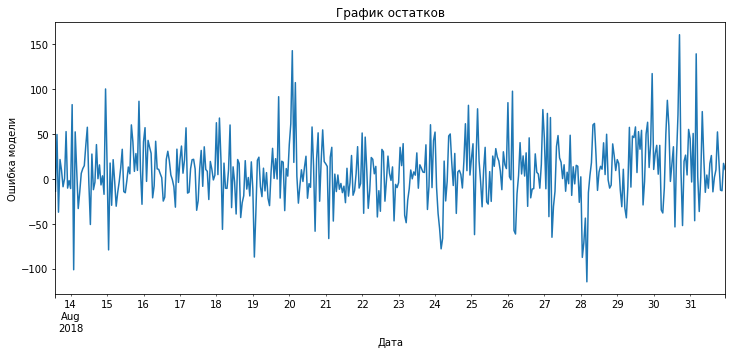

In [17]:
resids = test['num_orders'] - model.predict(test.drop('num_orders', axis=1))
resids.plot(figsize=(12,5))
plt.title('График остатков')
plt.ylabel('Ошибка модели')
plt.xlabel('Дата')
plt.show()

Для отдельных дней наблюдаются относительно большие отклонения, но в целом остатки имеют случайное распределение. При необходимости можно рассмотреть формирование дополнительных признаков для обучения модели.  

Таким образом, построенная модель удолетворяет предъявляемым к ней требованиям и не имеет очевидных недостатков.